<a href="https://colab.research.google.com/github/balilarder/master-ncku/blob/master/wavelet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 1. input a time series, interpolate, wavelet coefficient...
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
from datetime import datetime

# read air pollution csv file

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/master_research/dataset/beijing_17_18_aq.csv")    

stations_data = df.groupby('stationId')
# stations 為所有北京不同的station
stations = list(stations_data.groups.keys())
# for each station, generate its time series


date_rng = pd.date_range(start='1/1/2017 14:00', end='1/31/2018 15:00', freq='H')
def time_series(id, type):
    # id is a sensor, ex: aotizhongxin_aq
    # type is ex: pm25
    timestamp = list(date_rng)
    value = [np.nan]*len(timestamp)
    
    select = stations_data.get_group(id)
    select = select[['utc_time', type]]

    # fill the data:

    cur = 0
    for i in range(len(select.index)):
        
        for j in range(cur, len(timestamp)):
            
            if str(timestamp[j]) == select.iloc[i]['utc_time']:
                value[j] = select.iloc[i][type]
                cur = j

                break
            
    return value


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# 1d interpolate for np.nan
import math
y = np.array([1, 1, 1, np.nan, np.nan, 2, 2, np.nan, 0])

def interpolate_linear1d(i):
    x = []
    xp = []
    fp = []
#     xp = list(range(len(i)))
    for a in range(len(i)):
        if math.isnan(i[a]):
            x.append(a)
        else:
            xp.append(a)
            fp.append(i[a])

#     print(x)
#     print(xp)
#     print(fp)
    inter = np.interp(x, xp, fp)
    
    for a, b in zip(x, inter):
        i[a] = b
        
    return i

# 使用interpolate
a = interpolate_linear1d(y)
print(a)
print(len(a))

[1.         1.         1.         1.33333333 1.66666667 2.
 2.         1.         0.        ]
9


In [0]:
# 以表格方式呈現所有地方time series
d = []

for s in stations:
    print(s)
    v = time_series(s, 'PM2.5')
    dup = list(v)
    dup = dup         # 修正要取的data片段
    print(dup)
#     for n, i in enumerate(dup):
#         if np.isnan(i):
#             dup[n] = 1
            
#         else:
#             dup[n] = 0
    
    d.append(dup)

# # time and missing data之間顏色圖
plt.imshow(d, aspect='auto')
## imshow 裡面有interpolate方式，請注意


plt.grid(b=None)
plt.show()


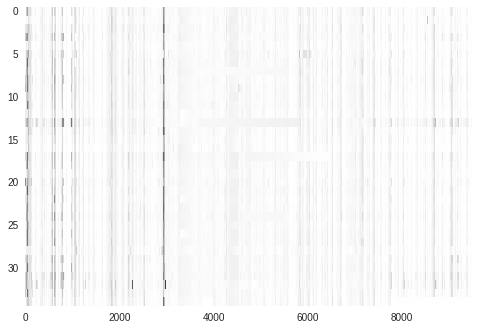

In [0]:
# linear interpolate show

d = []

for s in stations:
    v = time_series(s, 'PM2.5')
    dup = list(v)
    dup = interpolate_linear1d(dup)        

    
    d.append(dup)
plt.imshow(d, aspect='auto')
plt.grid(b=None)
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


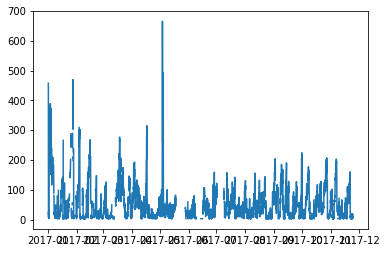

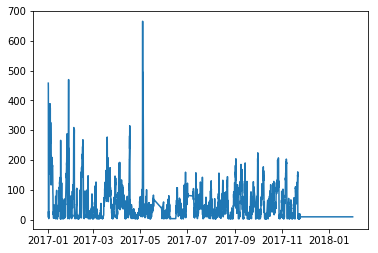

In [0]:
# 可以show出timeseries
v = time_series("zhiwuyuan_aq", 'PM2.5')
plt.plot(date_rng, v)
plt.show()

v = interpolate_linear1d(v)
plt.plot(date_rng, v)
plt.show()

In [0]:
# 有缺值的顯示

d = [[0, 1, 1, np.nan],
     [3, 0, 0, 1],
     [np.nan, np.nan, 2, 1]
    
]
# # time and missing data之間顏色圖
plt.imshow(d, aspect='auto')
## imshow 裡面有interpolate方式，請注意
plt.grid(b=None)
plt.show()

In [0]:
# Wavelet table
# i = [1, 1, 6, 8, 9, 11, 15]
i = time_series("dingling_aq", 'PM2.5')
def wavelet_coefficient_table(i):
    table = [['level', 'average', 'difference']]
    level = 1
    length = len(i)
    
    while(length > 1):
        if length % 2 == 0:
            length_next = int(length / 2)
        else:
            length_next = int((length+1) / 2)

        
#         print(length, length_next, level)
        
        average = ['x']*length_next
        difference = ['x']*length_next
        
        # 偶數
        if length % 2 == 0:
            for x in range(length_next):
                v1 = i[x*2]
                v2 = i[x*2 + 1]
                
#                 print('  ', v1, v2)
                average[x] = float((v1+v2) / 2)
                difference[x] = float((v1-v2) / 2)
        # 奇數
        else:
            # seperate series into 3 pieces
            m = int((length-1)/2)
            middle = i[m]
            before = i[:m]
            after = i[m + 1:]
            
            if len(before) % 2 == 0: # 前半後半可以各自形成
                for x in range(len(before) // 2):
                    v1 = before[x*2]
                    v2 = before[x*2 + 1]
                    average[x] = float((v1+v2) / 2)
                    difference[x] = float((v1-v2) / 2)
                for x, y in zip(range(int(m/2) + 1, length_next), range(len(after) // 2)):
                    v1 = after[y*2]
                    v2 = after[y*2 + 1]
                    average[x] = float((v1+v2) / 2)
                    difference[x] = float((v1-v2) / 2)
                # 中間那格必須和左右一起計算(共填一格)
                average[int((length_next-1)/2)] = (((before[-1]+middle)/2)+
                                                   ((middle+after[0])/2)) / 2
                difference[int((length_next-1)/2)] = (((before[-1]-middle)/2)+
                                                   ((middle-after[0])/2)) / 2
            
            else:
                del before[-1]
                del after[0]
                
                if before != []:
                    for x in range(int(length_next/2) - 1):
                        v1 = before[x*2]
                        v2 = before[x*2 + 1]
                        average[x] = float((v1+v2) / 2)
                        difference[x] = float((v1-v2) / 2)
                    for x, y in zip(range(int(length_next/2) + 1, length_next), range(len(after) // 2)):
                        v1 = after[y*2]
                        v2 = after[y*2 + 1]
                        average[x] = float((v1+v2) / 2)
                        difference[x] = float((v1-v2) / 2)
                # 填2個格子歐
                position1 = int(length_next/2) - 1
                position2 = position1 + 1
                average[position1] = (i[m-1] + middle) / 2
                average[position2] = (middle + i[m+1]) / 2
                difference[position1] = (i[m-1] - middle) / 2
                difference[position2] = (middle - i[m+1]) / 2
                
#         print(' ', average, difference)
        
        length = length_next
        i = average
        
        table.append([level, average, difference])
        level += 1
        
    return table

# for x in table:
#     print(table)

t = wavelet_coefficient_table(i)
print(t)
print(i)

[['level', 'average', 'difference'], [1, [341.0, 283.5, 39.5, 17.5, 10.5, 9.0, 12.5, 14.5, 31.0, 171.0, 213.0, 198.5, 175.5, 186.0, 188.0, 150.0, 142.0, 146.5, 155.5, 256.0, 212.5, 194.0, 206.5, 184.5, 141.5, 114.5, 74.0, 59.5, 56.5, 47.5, 67.0, 114.5, 131.5, 208.0, 260.0, 248.5, 253.5, 317.0, 411.0, 389.0, 315.5, 221.5, 234.5, 295.5, 184.5, nan, nan, nan, 162.5, 131.5, 137.5, 129.5, 129.0, 153.0, 209.0, 185.5, 171.0, 195.0, 197.0, 209.0, 209.0, 188.0, 195.0, 177.0, 172.5, 211.5, 257.0, 174.0, 33.5, 37.0, 39.0, 39.0, 31.5, 29.5, 26.5, 23.5, 22.0, 21.0, 22.5, 20.0, 21.5, 19.0, 12.5, 5.0, 11.0, 5.0, 12.5, 12.0, 14.5, 12.5, 12.5, 11.5, 9.0, 18.5, 57.0, 59.5, 65.5, 10.5, 6.0, 7.5, 9.5, 37.0, 23.0, 8.5, 5.5, 8.5, 5.5, 10.5, 10.5, 15.5, 14.0, 14.0, 12.5, 22.5, 60.0, 40.5, 27.0, 19.0, 17.5, 19.5, 14.0, 27.5, 15.5, 12.0, 22.5, 38.0, 30.5, 24.0, 21.5, 24.0, 20.0, 15.0, 18.0, 12.0, 9.0, 3.5, 10.0, 14.0, 16.0, 6.5, 14.5, 11.0, 5.5, 12.0, 16.5, 17.0, 11.5, 12.0, 18.5, 18.5, 18.0, 21.0, 39.5, 18.0,

aotizhongxin_aq
9482
badaling_aq
9482
beibuxinqu_aq
9482
daxing_aq
9482
dingling_aq
9482
donggaocun_aq
9482
dongsi_aq
9482
dongsihuan_aq
9482
fangshan_aq
9482
fengtaihuayuan_aq
9482
guanyuan_aq
9482
gucheng_aq
9482
huairou_aq
9482
liulihe_aq
9482
mentougou_aq
9482
miyun_aq
9482
miyunshuiku_aq
9482
nansanhuan_aq
9482
nongzhanguan_aq
9482
pingchang_aq
9482
pinggu_aq
9482
qianmen_aq
9482
shunyi_aq
9482
tiantan_aq
9482
tongzhou_aq
9482
wanliu_aq
9482
wanshouxigong_aq
9482
xizhimenbei_aq
9482
yanqin_aq
9482
yizhuang_aq
9482
yongdingmennei_aq
9482
yongledian_aq
9482
yufa_aq
9482
yungang_aq
9482
zhiwuyuan_aq
9482
1 [435.0, 407.5, 441.0, 163.5, 44.5, 18.5, 20.5, 117.0, 188.0, 236.0, 159.5, 131.0, 159.0, 250.0, 293.0, 296.0, 285.0, 238.5, 193.5, 168.5, 211.5, 295.5, 362.5, 450.5, 465.0, 451.5, 463.0, 480.5, 446.0, 338.0, 387.0, 191.5, 308.0, 344.5, 301.0, 351.0, 354.0, 185.5, 163.5, 215.5, 310.0, 273.0, 271.5, 244.0, 214.5, 173.0, 187.0, 209.0, 182.0, 184.0, 167.5, 164.5, 173.0, 172.5, 213.5, 1

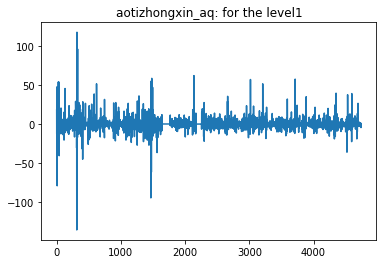

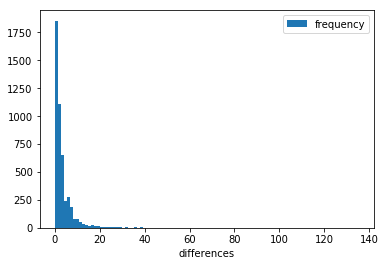

2 [421.25, 302.25, 31.5, 68.75, 212.0, 145.25, 204.5, 294.5, 261.75, 181.0, 253.5, 406.5, 458.25, 471.75, 392.0, 289.25, 326.25, 326.0, 269.75, 189.5, 291.5, 257.75, 193.75, 198.0, 183.0, 166.0, 172.75, 202.0, 212.5, 220.75, 238.5, 209.5, 168.5, 172.25, 116.25, 102.25, 75.75, 22.0, 17.25, 20.75, 16.5, 16.25, 10.25, 8.0, 11.5, 10.375, 25.75, 78.25, 92.0, 10.25, 8.0, 3.75, 4.5, 48.25, 89.0, 93.75, 35.25, 20.5, 53.25, 41.5, 30.75, 26.75, 16.75, 28.5, 83.25, 87.25, 14.0, 7.5, 13.0, 14.0, 9.25, 16.75, 14.0, 16.0, 15.0, 24.75, 15.0, 35.75, 32.75, 39.25, 24.75, 38.25, 65.25, 78.0, 78.5, 87.5, 86.0, 68.0, 101.5, 123.5, 132.5, 135.75, 138.75, 162.5, 141.5, 166.25, 108.25, 50.25, 22.75, 23.0, 40.25, 47.25, 62.25, 105.25, 106.75, 17.5, 9.25, 11.25, 10.0, 7.0, 10.25, 18.0, 21.5, 38.5, 63.75, 82.5, 13.5, 7.75, 6.75, 12.75, 10.75, 13.75, 12.0, 17.5, 28.75, 53.25, 25.75, 16.0, 12.0, 17.5, 30.25, 58.5, 91.125, 96.75, 47.625, 49.25, 95.375, 128.6, 137.9, 199.75, 167.25, 148.25, 164.75, 206.1875, 259.62

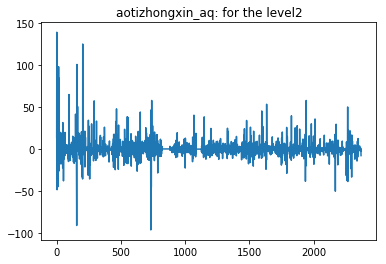

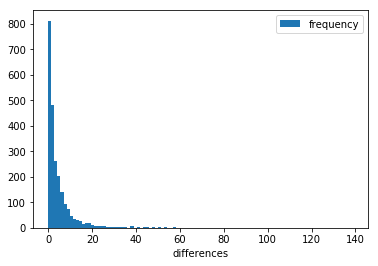

3 [361.75, 50.125, 178.625, 249.5, 221.375, 330.0, 465.0, 340.625, 326.125, 229.625, 274.625, 195.875, 174.5, 187.375, 216.625, 224.0, 170.375, 109.25, 48.875, 19.0, 16.375, 9.125, 10.9375, 52.0, 51.125, 5.875, 26.375, 91.375, 27.875, 47.375, 28.75, 22.625, 85.25, 10.75, 13.5, 13.0, 15.0, 19.875, 25.375, 36.0, 31.5, 71.625, 83.0, 77.0, 112.5, 134.125, 150.625, 153.875, 79.25, 22.875, 43.75, 83.75, 62.125, 10.25, 8.5, 14.125, 30.0, 73.125, 10.625, 9.75, 12.25, 14.75, 41.0, 20.875, 14.75, 44.375, 93.9375, 48.4375, 111.9875, 168.825, 157.75, 185.46875, 286.28125, 241.875, 47.53846153846153, 15.46153846153846, 22.041666666666668, 80.20833333333333, 510.75, 373.625, 244.875, 174.375, 10.5, 9.75, 7.875, 6.625, 47.375, 82.5, 85.75, 64.625, 6.5, 8.375, 19.02777777777778, 34.63888888888889, 49.89583333333333, 95.125, 148.125, 89.125, 205.625, 327.875, 307.125, 222.875, 13.875, 10.625, 10.875, 7.625, 5.25, 13.75, 58.25, 67.25, 92.125, 112.9375, 16.0625, 9.5625, 8.363636363636363, 7.3863636363636

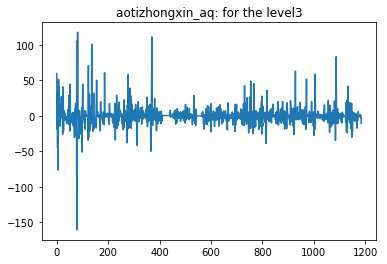

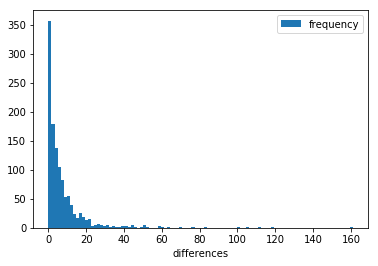

4 [205.9375, 214.0625, 275.6875, 402.8125, 277.875, 235.25, 180.9375, 220.3125, 139.8125, 33.9375, 12.75, 31.46875, 28.5, 58.875, 37.625, 25.6875, 48.0, 13.25, 17.4375, 30.6875, 51.5625, 80.0, 123.3125, 152.25, 51.0625, 63.75, 36.1875, 11.3125, 51.5625, 10.1875, 13.5, 30.9375, 29.5625, 71.1875, 140.40625, 171.609375, 264.078125, 31.499999999999996, 51.125, 442.1875, 209.625, 10.125, 7.25, 64.9375, 75.1875, 7.4375, 26.833333333333336, 72.51041666666666, 118.625, 266.75, 265.0, 12.25, 9.25, 9.5, 62.75, 102.53125, 12.8125, 7.875, 6.625, 7.125, 13.875, 96.3125, 94.875, 116.4375, 94.75, 187.25, 244.6875, 265.890625, 74.359375, 7.6875, 50.5625, 82.125, 156.4375, 22.25, 9.78125, 64.875, 55.8125, 88.4375, 12.875, 27.625, 16.5, 10.625, 16.3125, 28.25, 77.75, 48.3125, 10.25, 10.3125, 10.75, 40.6875, 84.75, 70.75, 94.3125, 41.3125, 10.25, 17.375, 6.34375, 6.5, 10.75, 10.09375, 15.0, 30.875, 77.8125, 13.015625, 7.609375, 6.65625, 10.555147058823529, 16.60110294117647, 50.875, 92.15, 111.8187500000

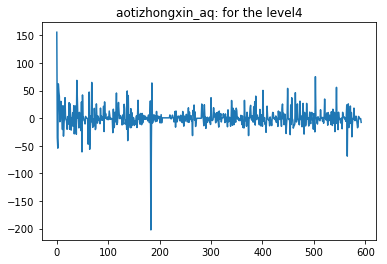

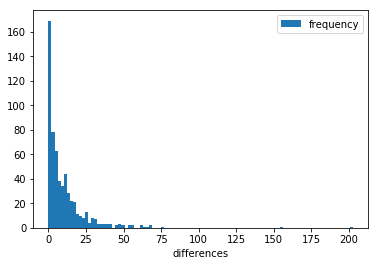

5 [210.0, 339.25, 256.5625, 200.625, 86.875, 22.109375, 43.6875, 31.65625, 30.625, 24.0625, 65.78125, 137.78125, 57.40625, 23.75, 30.875, 22.21875, 50.375, 156.0078125, 147.7890625, 246.65625, 109.875, 36.09375, 41.3125, 49.671875, 192.6875, 138.625, 9.375, 82.640625, 10.34375, 6.875, 55.09375, 105.65625, 141.0, 255.2890625, 41.0234375, 66.34375, 89.34375, 37.328125, 72.125, 20.25, 13.5625, 22.28125, 63.03125, 10.28125, 25.71875, 77.75, 67.8125, 13.8125, 6.421875, 10.421875, 22.9375, 45.4140625, 7.1328125, 13.578125, 71.5125, 103.12812500000001, 150.15625, 214.34375, 102.96875, 129.015625, 116.53125, 53.84375, 12.28125, 20.125, 86.609375, 98.0, 24.875, 45.46875, 114.8125, 107.1875, 72.5, 84.15625, 84.53125, 63.5625, 36.84375, 28.0625, 65.09375, 36.46875, 101.53125, 77.421875, 45.21875, 46.446875, 36.4203125, 28.035773026315788, 30.37828947368421, 12.859375, 17.578125, 27.65625, 44.90625, 39.0625, 61.40625, 170.90625, 246.09375, 51.171875, 37.171875, 53.65625, 41.5, 43.15625, 35.953125,

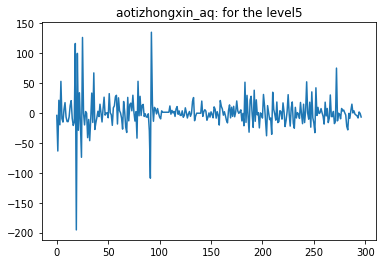

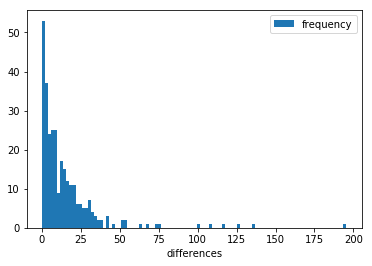

6 [274.625, 228.59375, 54.4921875, 37.671875, 27.34375, 101.78125, 40.578125, 26.546875, 103.19140625, 197.22265625, 72.984375, 45.4921875, 165.65625, 46.0078125, 8.609375, 80.375, 198.14453125, 53.68359375, 63.3359375, 46.1875, 17.921875, 36.65625, 51.734375, 40.8125, 8.421875, 34.17578125, 10.35546875, 87.3203125, 182.25, 115.9921875, 85.1875, 16.203125, 92.3046875, 35.171875, 111.0, 78.328125, 74.046875, 32.453125, 50.78125, 89.4765625, 45.8328125, 32.228042763157895, 21.618832236842103, 22.6171875, 41.984375, 116.15625, 148.6328125, 45.4140625, 42.328125, 25.625, 47.6875, 90.78732287449392, 79.4493927125506, 69.08502024291498, 58.72064777327935, 32.9768471659919, 25.32451923076923, 40.03125, 40.796875, 21.84375, 31.234375, 36.1875, 66.234375, 32.9375, 27.2109375, 22.546875, 71.3828125, 72.48234097633136, 102.59467455621301, 105.2455621301775, 84.7555473372781, 50.30798611111111, 32.223263888888894, 54.671875, 56.421875, 68.890625, 25.9609375, 31.625, 31.0234375, 53.203125, 39.84375

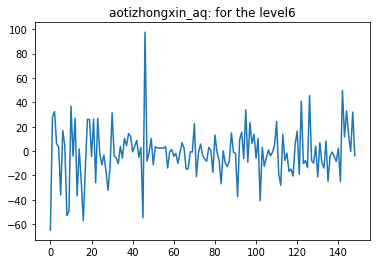

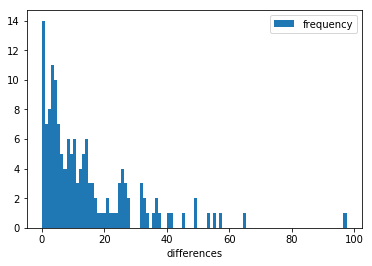

7 [251.609375, 46.08203125, 64.5625, 33.5625, 150.20703125, 59.23828125, 105.83203125, 44.4921875, 125.9140625, 54.76171875, 27.2890625, 46.2734375, 21.298828125, 48.837890625, 149.12109375, 50.6953125, 63.73828125, 94.6640625, 53.25, 70.12890625, 39.030427631578945, 22.11800986842105, 79.0703125, 97.0234375, 33.9765625, 69.23741143724696, 74.2672064777328, 45.848747469635626, 32.67788461538461, 31.3203125, 33.7109375, 49.5859375, 24.87890625, 71.93257673816568, 103.92011834319526, 67.53176672419461, 43.44756944444445, 59.1015625, 47.42578125, 31.32421875, 46.5234375, 20.84375, 47.203125, 44.6328125, 48.83203125, 17.56640625, 92.35546875, 66.3203125, 59.80859375, 36.33203125, 56.328125, 56.56640625, 33.5234375, 57.5859375, 38.3203125, 74.484375, 106.859375, 41.0234375, 77.8984375, 28.8984375, 26.5546875, 64.0, 35.06640625, 60.84375, 17.04296875, 27.64453125, 22.59375, 28.546875, 97.5859375, 23.6640625, 17.0625, 61.2109375, 50.8203125, 16.390625, 26.78125] [23.015625, 8.41015625, -37.21

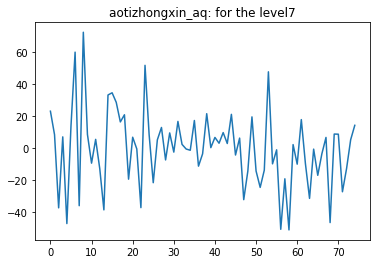

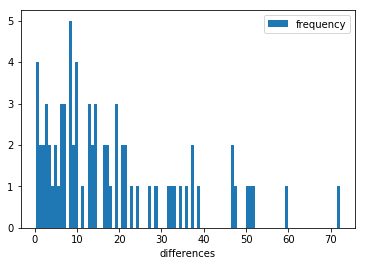

8 [148.845703125, 49.0625, 104.72265625, 75.162109375, 90.337890625, 36.78125, 35.068359375, 99.908203125, 79.201171875, 61.689453125, 30.57421875, 88.046875, 51.60698696862348, 60.05797697368421, 31.999098557692307, 41.6484375, 48.40574149408284, 85.72594253369493, 51.27456597222222, 53.263671875, 38.923828125, 34.0234375, 46.732421875, 54.9609375, 63.064453125, 46.330078125, 45.044921875, 47.953125, 90.671875, 59.4609375, 27.7265625, 49.533203125, 38.943359375, 25.119140625, 63.06640625, 20.36328125, 56.015625, 21.5859375] [102.763671875, 15.5, 45.484375, 30.669921875, 35.576171875, -9.4921875, -13.76953125, 49.212890625, -15.462890625, -8.439453125, 8.456208881578947, -8.9765625, -17.63042446862348, 14.209229504048587, 0.6787860576923066, -7.9375, -23.52683524408284, 18.194175809500322, -7.826996527777776, 5.837890625, -7.599609375, -13.1796875, -2.099609375, -37.39453125, 3.255859375, -9.998046875, 11.521484375, 9.6328125, -16.1875, -18.4375, 1.171875, 14.466796875, 21.900390625, 2

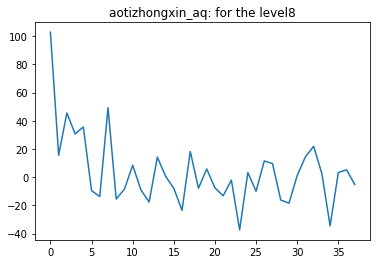

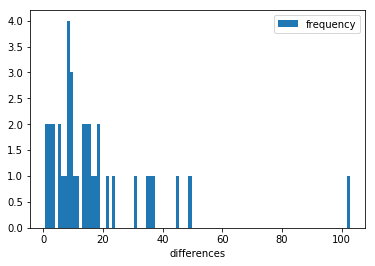

9 [98.9541015625, 89.9423828125, 63.5595703125, 67.48828125, 70.4453125, 59.310546875, 55.83248197115385, 36.82376802884615, 67.06584201388888, 52.26911892361111, 36.4736328125, 50.8466796875, 54.697265625, 46.4990234375, 75.06640625, 38.6298828125, 32.03125, 41.71484375, 38.80078125] [49.8916015625, 14.7802734375, 26.7783203125, -32.419921875, 8.755859375, -28.736328125, -4.225495002530366, -4.824669471153847, -18.660100519806047, -0.99455295138889, 2.4501953125, -4.1142578125, 8.3671875, -1.4541015625, 15.60546875, -10.9033203125, 6.912109375, 21.3515625, 17.21484375]


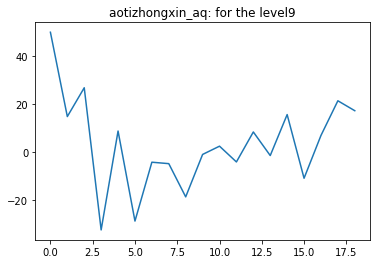

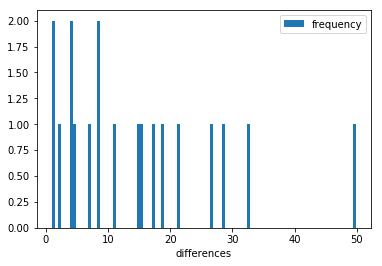

10 [94.4482421875, 65.52392578125, 64.8779296875, 46.328125, 59.66748046875, 44.37137586805555, 52.77197265625, 60.78271484375, 35.33056640625, 40.2578125] [4.505859375, -1.96435546875, 5.5673828125, 9.504356971153847, 7.398361545138886, 7.897743055555555, -1.92529296875, -14.28369140625, 3.29931640625, 1.45703125]


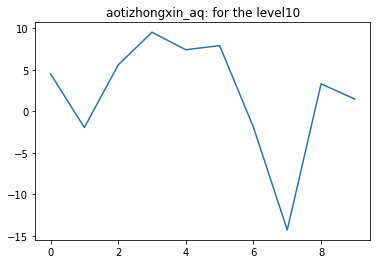

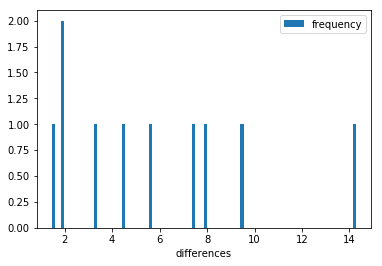

11 [79.986083984375, 55.60302734375, 52.019428168402776, 56.77734375, 37.794189453125] [14.462158203125, 9.27490234375, 7.648052300347224, -4.00537109375, -2.463623046875]


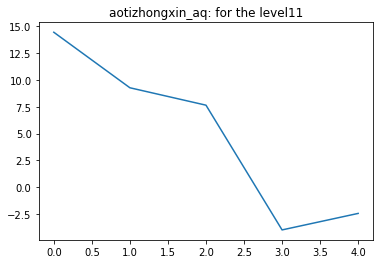

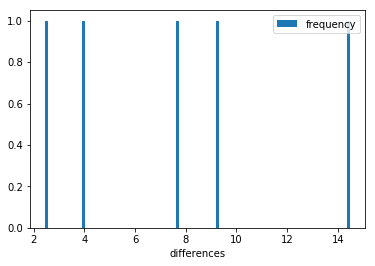

12 [67.7945556640625, 54.10480685763889, 47.2857666015625] [12.1915283203125, -0.2935791015625, 9.4915771484375]


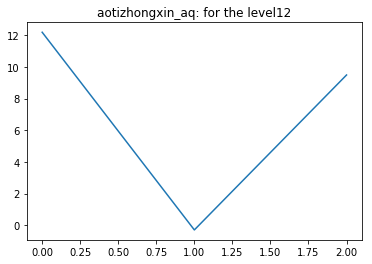

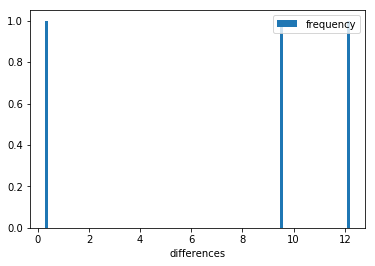

13 [60.949681260850696, 50.695286729600696] [6.844874403211804, 3.4095201280381957]


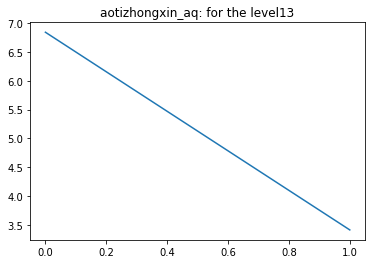

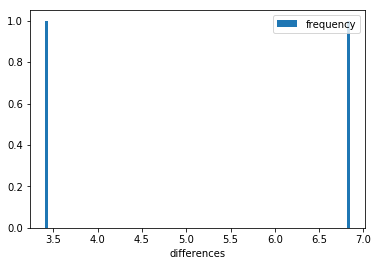

14 [55.822483995225696] [5.127197265625]


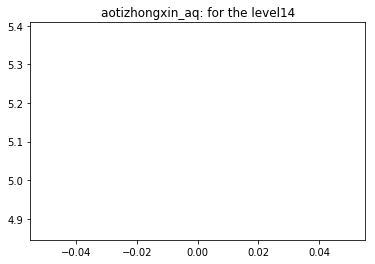

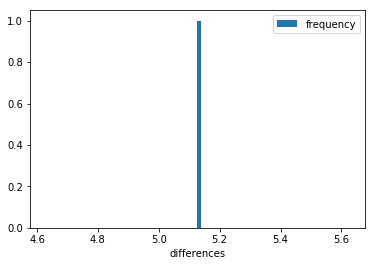

4
[205.9375, 214.0625, 275.6875, 402.8125, 277.875, 235.25, 180.9375, 220.3125, 139.8125, 33.9375, 12.75, 31.46875, 28.5, 58.875, 37.625, 25.6875, 48.0, 13.25, 17.4375, 30.6875, 51.5625, 80.0, 123.3125, 152.25, 51.0625, 63.75, 36.1875, 11.3125, 51.5625, 10.1875, 13.5, 30.9375, 29.5625, 71.1875, 140.40625, 171.609375, 264.078125, 31.499999999999996, 51.125, 442.1875, 209.625, 10.125, 7.25, 64.9375, 75.1875, 7.4375, 26.833333333333336, 72.51041666666666, 118.625, 266.75, 265.0, 12.25, 9.25, 9.5, 62.75, 102.53125, 12.8125, 7.875, 6.625, 7.125, 13.875, 96.3125, 94.875, 116.4375, 94.75, 187.25, 244.6875, 265.890625, 74.359375, 7.6875, 50.5625, 82.125, 156.4375, 22.25, 9.78125, 64.875, 55.8125, 88.4375, 12.875, 27.625, 16.5, 10.625, 16.3125, 28.25, 77.75, 48.3125, 10.25, 10.3125, 10.75, 40.6875, 84.75, 70.75, 94.3125, 41.3125, 10.25, 17.375, 6.34375, 6.5, 10.75, 10.09375, 15.0, 30.875, 77.8125, 13.015625, 7.609375, 6.65625, 10.555147058823529, 16.60110294117647, 50.875, 92.15, 111.8187500000

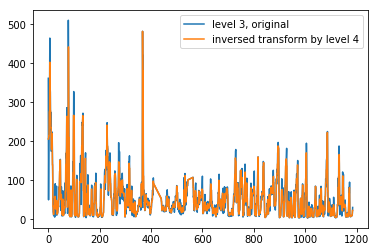

[205.9375, 205.9375, 214.0625, 214.0625, 275.6875, 275.6875, 402.8125, 402.8125, 277.875, 277.875, 235.25, 235.25, 180.9375, 180.9375, 220.3125, 220.3125, 139.8125, 139.8125, 33.9375, 33.9375, 12.75, 12.75, 31.46875, 31.46875, 28.5, 28.5, 58.875, 58.875, 37.625, 37.625, 25.6875, 25.6875, 48.0, 48.0, 13.25, 13.25, 17.4375, 17.4375, 30.6875, 30.6875, 51.5625, 51.5625, 80.0, 80.0, 123.3125, 123.3125, 152.25, 152.25, 51.0625, 51.0625, 63.75, 63.75, 36.1875, 36.1875, 11.3125, 11.3125, 51.5625, 51.5625, 10.1875, 10.1875, 13.5, 13.5, 30.9375, 30.9375, 29.5625, 29.5625, 71.1875, 71.1875, 140.40625, 140.40625, 171.609375, 171.609375, 264.078125, 264.078125, 31.499999999999996, 31.499999999999996, 51.125, 51.125, 442.1875, 442.1875, 209.625, 209.625, 10.125, 10.125, 7.25, 7.25, 64.9375, 64.9375, 75.1875, 75.1875, 7.4375, 7.4375, 26.833333333333336, 26.833333333333336, 72.51041666666666, 72.51041666666666, 118.625, 118.625, 266.75, 266.75, 265.0, 265.0, 12.25, 12.25, 9.25, 9.25, 9.5, 9.5, 62.75, 

In [0]:
%%time
import random

# 觀察table的level, difference的關係, choose some sensors
tables = {}
origin_level_0 = {}
# for s in stations[:1]:
for s in stations:  # 取(多)全部測站，之後應把小波表弄成json避免每次都要計算所有測站
    print(s)
    v = time_series(s, 'PM2.5')
    v = interpolate_linear1d(v)
    print(len(v))
    tables[s] = wavelet_coefficient_table(v)
    origin_level_0[s] = v
    
def wavelet_coefficient_distribution(level, list_diff, stationid):
    # ex: {1: [x, x, x,... ]}
    '''
    output: a plot and distribution plot.
    Use this fuction many times, can obtain all coefficients for different levels and its frequency
    '''
#     plt.plot([1, 2, 3, 4], [1, 4, 9, 16], 'ro')
    
    xdata = range(len(list_diff))
    plt.plot(xdata, list_diff)
    plt.title(label=str(stationid)+": for the level" + str(level))
    plt.show()
    # distribution histogram
    abs_diff = list(map(abs, list_diff))
    
    bin_value = plt.hist(abs_diff, bins = 100, label='frequency')    # bins now no matters, just help to show
    plt.xlabel('differences')
    
    plt.legend(loc='upper right')
    plt.show()
#     print(bin_value)
    
    
# 給一個level, try不同alpha(threshold概念)，filter需要的係數，用他們來還原成上一個level的資料
# 當然alpha越高越像，因為會包含更多係數，但是變像的程度若不夠大只有一點點幫助那就定住，return final optimal-alpha
def inverse_transform(level, datas_avg, datas_dif, alpha=0):
    # 先能產生一個boundary..
    boundary = '?'
    
    # diff取絕對值
    print("取絕對值")
    abs_diff = list(map(abs, datas_dif))
#     print(abs_diff)
    abs_diff.sort(reverse=True)
#     print(datas_dif)
#     print(abs_diff)
    
    try:
        boundary = abs_diff[int(len(datas_dif)*alpha)]
    except IndexError:
        boundary = 0 # no threshold
    print("bounadary is %f" %(boundary))
    
    # gen a pair(i, j) 以取代一堆bool, 這是標記出level i, 的第j位超過要的boundary
    
    evolving = [] # is a boolean list, tell if it is be classfied as pattern
    
    for i in range(len(datas_dif)):
        if abs(datas_dif[i]) >= boundary:
#             evolving.append((level, i))
            evolving.append(1)
        else:
            datas_dif[i] = 0 # filter too small fluctuation
            evolving.append(0)
#     print(datas_dif)
#     print(len(datas_avg), len(datas_dif), len(evolving))
    
    # 至於如何inverse, 就先用簡單的斜率概念，反正這也只是前後相減值, 目前想法：我就當那些相減值為0, 也就是不變(那段＝constant)
    inversed_data = []  # 長度是datas的2倍
    for x, y in zip(datas_avg, datas_dif):
        inversed_data.extend([x+y, x-y])
    return (inversed_data, evolving)


for x in tables['aotizhongxin_aq'][1:]:
    print(x[0], x[1], x[2]) # level, average, difference
    pic = wavelet_coefficient_distribution(x[0], x[2], 'aotizhongxin_aq')
#     break


test = tables['aotizhongxin_aq'][4]


level, average, diff = test[0], test[1].copy(), test[2].copy()

# level = 3
# average = [1, 7, 10, 20]
# diff = [0, -1, -1, -5]
print(level)
print(average)
print(diff)

inv, evol = inverse_transform(level, average, diff)
print(inv)

y1 = tables['aotizhongxin_aq'][3][1]
y2 = inv
plt.plot(range(len(y1)), y1, label='level 3, original')
plt.plot(range(len(y2)), y2, label='inversed transform by level 4')
plt.legend(loc='upper right')
plt.show()
print(y2)



In [0]:
# alpha v.s. RMSE關係

x = []
rmse = []
for alpha in np.linspace(0, 1, 101):
    print(alpha)
    level, average, diff = test[0], test[1].copy(), test[2].copy()
    inv, evol = inverse_transform(level, average, diff, alpha)
    origin = tables['aotizhongxin_aq'][3][1]
#     print(inv)
#     print(origin)
    rms = sqrt(mean_squared_error(origin, inv))
    x.append(alpha)
    rmse.append(rms)
    
plt.plot(x, rmse)
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.show()

print(rmse)

In [0]:
%%time
# 要跑

# 重要關頭：wavelet coefficient coordinate and scheduler
'''
重要的變數
tables: 小波轉換的結果，但是是原始data的
origin_level_0: raw data
'''

import random
def mapping_level_index(index, level, data_length):
    outcome_index = None
    initial_level = 0
    # 不用擔心level太大以至於沒有index的問題，因為只要初始index在origin data長度內，總是可以找到下一個level的對應index
    while index < data_length and data_length > 1:
        if data_length % 2 == 0:
            data_length = int(data_length / 2)
            index = int(index / 2)
            initial_level += 1
        else: # 奇數，有2個case
            if ((data_length-1)/2)%2 == 0: # 前半後半可以剛好形成
                
                if int((data_length-1)/2) == index: # 中間那格
                    index = int(index / 2)
                elif index < int((data_length-1)/2): # 前半段
                    index = int(index / 2)
                elif index > int((data_length-1)/2): # 後半段
                    index = int(math.ceil(index / 2))
                data_length = int((data_length-1)/2 + 1)
                initial_level += 1
                
            else: # 只用前半後半會剩，必須搭配中間那格(多一格)
                
                if int((data_length-1)/2) == index: # 中間那格隨機選兩格中的一個
                    r = random.uniform(0, 1)
                    if r >= 0.5:
                        index = int((data_length-3)/2/2 + 1)
                    else:
                        index = int((data_length-3)/2/2)
                
                elif index == int((data_length-1)/2) - 1: # 中間那格的左邊
                    index = int((data_length-3)/2/2)
                elif index == int((data_length-1)/2) + 1: # 中間那格的右邊
                    index = int((data_length-3)/2/2 + 1)
                
                elif index < int((data_length-1)/2) - 1:
                    index = int(index / 2)
                elif index > int((data_length-1)/2) + 1:
                    index = int(math.ceil(index / 2))
                    
                data_length = int((data_length-3)/2 + 2)
                initial_level += 1
                
        if initial_level == level:
            outcome_index = index
#             print("break", index, data_length)
            break
    return outcome_index


sample_timestamp = []
def diff_avg_coordinate_sample(sample=100, level=3):
    # from original data random choose sample to do wavelet transform
    cnt = 0
    while cnt < sample:
        a = random.randint(0, len(date_rng)-1)
#         a = random.randint(0, 1000)  # 控制隨機變數要娶原本data的多少
#         print(a)
        t = mapping_level_index(a, level, len(date_rng))
        if t != None:
            sample_timestamp.append([a, t])
            cnt += 1 
            
    # 拉出座標(x: average, y: difference), 不能用原本的小波表，因為那是用全部data做出來的 ['level', 'average', 'difference']
    # 先拿原始data重新slicing, 用sample出來的timestamp做小波轉換
    x = []
    y = []
    
    for t in sample_timestamp:
        for s in stations:

            d = (origin_level_0[s])[:t[0]] # 產生新的data slice, 做小波

            slice_wavelet = wavelet_coefficient_table(d)        
            x.append(abs(slice_wavelet[level][1][-1]))
            y.append(abs(slice_wavelet[level][2][-1]))
        
    return (x, y)
sample = 100
coordinate = diff_avg_coordinate_sample(sample=sample, level=3)
print(coordinate[0])
print(coordinate[1])



[4.9375, 17.375, 46.0, 9.875, 7.875, 7.0, 6.875, 17.375, 19.25, 12.375, 11.375, 7.375, 8.5625, 11.0625, 6.5, 10.625, 4.75, 17.25, 16.348684210526315, 19.0, 9.875, 14.5, 12.5, 9.375, 18.125, 12.5, 14.875, 11.0, 8.25, 7.75, 7.375, 22.3125, 15.125, 8.375, 8.375, 177.0, 71.375, 172.0, 179.25, 126.75, 158.75, 183.625, 184.875, 184.0, 190.125, 161.375, 175.25, 157.875, 211.375, 144.25, 165.625, 143.75, 183.875, 178.5, 142.125, 161.375, 171.125, 170.75, 161.75, 206.25, 161.625, 181.75, 175.375, 155.625, 208.75, 177.375, 182.125, 171.125, 185.75, 154.875, 22.0, 16.125, 21.75, 19.875, 22.375, 25.125, 31.75, 29.347124117053482, 23.25, 23.125, 23.490384615384613, 30.375, 27.0, 67.22638436482085, 27.0, 22.375, 14.125, 59.35714285714286, 31.375, 19.125, 26.5, 29.875, 24.0625, 25.0, 41.25, 30.0, 29.75, 29.875, 19.30357142857143, 26.375, 26.0, 30.125, 22.375, 24.625, 3.0, 229.25, 37.75, 151.625, 515.25, 211.5, 300.0, 293.25, 322.75, 479.5, 365.5, 284.02173913043475, 313.5, 116.25, 502.875, 264.0, 104

36.6875 3.0
[52.125, 25.25, 42.75, 55.625, 29.125, 45.125, 65.625, 24.34207870837538, 56.125, 57.75, 53.375, 51.75, 40.625, 53.76099348534202, 32.5, 43.75, 41.125, 65.0, 66.1875, 34.625, 52.875, 63.5, 61.875, 52.875, 62.875, 52.25, 54.625, 58.75, 32.75, 56.625, 57.875, 40.55769230769231, 56.0, 48.625, 20.25]
[10.125, 4.5, 8.25, 5.875, 6.375, 9.375, 13.875, 0.040363269424823045, 4.875, 11.75, 13.875, 10.5, 10.875, 4.26099348534202, 9.25, 7.75, 2.875, 5.25, 13.6875, 11.625, 9.875, 13.5, 3.125, 9.875, 8.875, 11.75, 14.375, 9.25, 1.75, 7.125, 7.375, 0.16742081447963741, 5.25, 13.875, 5.5]
[126.0, 69.9375, 100.5, 109.0625, 70.75, 118.0, 145.0, 125.5, 126.08333333333334, 123.625, 130.5, 121.25, 116.375, 112.375, 110.5, 125.25, 125.0, 145.125, 128.75, 83.875, 158.0, 135.25, 121.375, 118.125, 151.3125, 106.5, 127.75, 145.75, 85.875, 124.0625, 122.875, 120.375, 100.125, 100.875, 99.0]
[4.5, 10.3125, 25.0, 12.0625, 4.75, 15.75, 0.25, 8.75, 1.0833333333333357, 10.125, 0.0, 0.0, 15.125, 31.875, 16

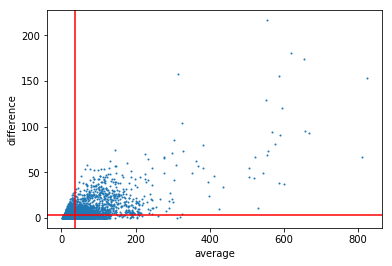

In [0]:
import statistics

# 畫出圖
plt.scatter(coordinate[0], coordinate[1], s=1)
# 中位數
avg_m = statistics.median(coordinate[0])
diff_m = statistics.median(coordinate[1])
print(avg_m, diff_m)
plt.axhline(y=diff_m, color= 'r')
plt.axvline(x=avg_m, color= 'r')
plt.xlabel('average')
plt.ylabel('difference')

diffHavgH = []
diffHavgL = []
diffLavgH = []
diffLavgL = []
# 一個timestamp是一個iteration
for i, j in zip(range(0, len(coordinate[0]), len(stations)), [a[0] for a in sample_timestamp]):
#     print(i, j)    # i is coordinate, j is timestamp
#     print("average", coordinate[0][i:i+len(stations)])
    average_split = coordinate[0][i:i+len(stations)]
#     print("difference", coordinate[1][i:i+len(stations)])
    difference_split = coordinate[1][i:i+len(stations)]
    print(average_split)
    print(difference_split)
    # check every coordinate and classify into 4 cases
    for x, y, s in zip(average_split, difference_split, stations):
#         print(x, y, s, j)
        d = {}
        d['average'] = x
        d['difference'] = y
        d['timestamp'] = j
        d['station'] = s
        if x > avg_m and y > diff_m:
            diffHavgH.append(d)
        elif x > avg_m and y <= diff_m:
            diffLavgH.append(d)
        elif x <= avg_m and y > diff_m:
            diffHavgL.append(d)
        elif x <= avg_m and y <= diff_m:
            diffLavgL.append(d)
a = len(diffHavgH)
b = len(diffHavgL)
c = len(diffLavgH)
d = len(diffLavgL)
print(a, b, c, d)

3500
68008.18137897756 0 34004.09068948878
3500
29837.6229739501 8864 19350.81148697505
3500
21670.826573607603 13960 17815.4132868038
3500
10703.586134356608 19096 14899.793067178303
3500
0 28000 14000.0
[68008.18137897756, 29837.6229739501, 21670.826573607603, 10703.586134356608, 0]
[0, 8864, 13960, 19096, 28000]
[34004.09068948878, 19350.81148697505, 17815.4132868038, 14899.793067178303, 14000.0]


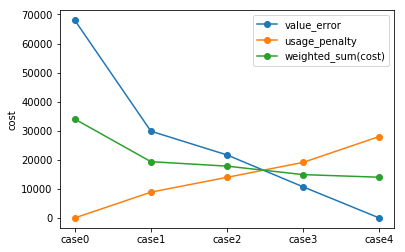

In [0]:
# 每個類別開開看
# 按照順序prority大到小
def cost_function(set_type, level, error_type, alpha):
    '''
    set_type=diffHavgH, diffHavgL, diffLavgH, diffLavgL, all_sleep, all_active
    level決定"next timestamp開多久", e.x.level=3
    error_type=RMSE, MAPE...
    alpha是weight
        
    return 2 value: average error and average usage
    '''
    if set_type == "all_sleep": # use the last value to duplicate next timestamp's data
        times = [x[0] for x in sample_timestamp]
        compute_cnt = 0
        value_error = 0
        usage_penalty = 0
        weighted_sum = 0
        
        sleep = diffHavgH + diffHavgL + diffLavgH + diffLavgL
        for x in sleep:  # sleep
            s = x['station']
            t = x['timestamp']
            current = origin_level_0[s][t]
            estimate = [current]*(2**level)
            actual = origin_level_0[s][t+1:t+1+(2**level)]
            if error_type == "RMSE":
                rms = sqrt(mean_squared_error(estimate, actual))
            value_error += rms
            compute_cnt += 1
            
        print(compute_cnt)
        weighted_sum = alpha*usage_penalty + (1-alpha)*value_error
    
    if set_type == "case1": # let diffHavgH active, others 3 set sleep
        times = [x[0] for x in sample_timestamp]
        compute_cnt = 0
        value_error = 0
        usage_penalty = 0
        weighted_sum = 0

        for x in diffHavgH: # active
            s = x['station']
            t = x['timestamp']
            usage_penalty += (2**level)
            compute_cnt += 1
            
        sleep = diffHavgL + diffLavgH + diffLavgL
        for x in sleep:  # sleep
            s = x['station']
            t = x['timestamp']
            current = origin_level_0[s][t]
            estimate = [current]*(2**level)
            actual = origin_level_0[s][t+1:t+1+(2**level)]
            if error_type == "RMSE":
                rms = sqrt(mean_squared_error(estimate, actual))
            value_error += rms
            compute_cnt += 1
        print(compute_cnt)
        weighted_sum = alpha*usage_penalty + (1-alpha)*value_error
        
    if set_type == "case2": # let diffHavgH+diffHavgL active, others 2 set sleep
        times = [x[0] for x in sample_timestamp]
        compute_cnt = 0
        value_error = 0
        usage_penalty = 0
        weighted_sum = 0

        active = diffHavgH + diffHavgL
        for x in active: # active
            s = x['station']
            t = x['timestamp']
            usage_penalty += (2**level)
            compute_cnt += 1
            
        sleep = diffLavgH + diffLavgL
        for x in sleep:  # sleep
            s = x['station']
            t = x['timestamp']
            current = origin_level_0[s][t]
            estimate = [current]*(2**level)
            actual = origin_level_0[s][t+1:t+1+(2**level)]
            if error_type == "RMSE":
                rms = sqrt(mean_squared_error(estimate, actual))
            value_error += rms
            compute_cnt += 1
        print(compute_cnt)
        weighted_sum = alpha*usage_penalty + (1-alpha)*value_error
        
        
    if set_type == "case3": # let diffHavgH+diffHavgL+diffLavgH active, last 1 set sleep
        times = [x[0] for x in sample_timestamp]
        compute_cnt = 0
        value_error = 0
        usage_penalty = 0
        weighted_sum = 0

        active = diffHavgH + diffHavgL + diffLavgH
        for x in active: # active
            s = x['station']
            t = x['timestamp']
            usage_penalty += (2**level)
            compute_cnt += 1
            
        for x in diffLavgL:  # sleep
            s = x['station']
            t = x['timestamp']
            current = origin_level_0[s][t]
            estimate = [current]*(2**level)
            actual = origin_level_0[s][t+1:t+1+(2**level)]
            if error_type == "RMSE":
                rms = sqrt(mean_squared_error(estimate, actual))
            value_error += rms
            compute_cnt += 1
        print(compute_cnt)
        weighted_sum = alpha*usage_penalty + (1-alpha)*value_error
        
        
    if set_type == "all_active": 
        times = [x[0] for x in sample_timestamp]
        compute_cnt = 0
        value_error = 0
        usage_penalty = 0
        weighted_sum = 0

        active = diffHavgH + diffHavgL + diffLavgH + diffLavgL
        for x in active: # active
            s = x['station']
            t = x['timestamp']
            usage_penalty += (2**level)
            compute_cnt += 1
        print(compute_cnt)
        weighted_sum = alpha*usage_penalty + (1-alpha)*value_error
    
    
    return value_error, usage_penalty, weighted_sum


# 秀實驗圖
alpha = 0.5
x = range(5)
y1 = []
y2 = []
y3 = []

value_error, usage_penalty, weighted_sum = cost_function(set_type = "all_sleep", level=3, error_type = "RMSE", alpha = alpha)
print(value_error, usage_penalty, weighted_sum)
y1.append(value_error)
y2.append(usage_penalty)
y3.append(weighted_sum)

value_error, usage_penalty, weighted_sum = cost_function(set_type = "case1", level=3, error_type = "RMSE", alpha = alpha)
print(value_error, usage_penalty, weighted_sum)
y1.append(value_error)
y2.append(usage_penalty)
y3.append(weighted_sum)


value_error, usage_penalty, weighted_sum = cost_function(set_type = "case2", level=3, error_type = "RMSE", alpha = alpha)
print(value_error, usage_penalty, weighted_sum)
y1.append(value_error)
y2.append(usage_penalty)
y3.append(weighted_sum)

value_error, usage_penalty, weighted_sum = cost_function(set_type = "case3", level=3, error_type = "RMSE", alpha = alpha)
print(value_error, usage_penalty, weighted_sum)
y1.append(value_error)
y2.append(usage_penalty)
y3.append(weighted_sum)

value_error, usage_penalty, weighted_sum = cost_function(set_type = "all_active", level=3, error_type = "RMSE", alpha = alpha)
print(value_error, usage_penalty, weighted_sum)
y1.append(value_error)
y2.append(usage_penalty)
y3.append(weighted_sum)

print(y1)
print(y2)
print(y3)
plt.plot(x, y1, 'o-' ,x, y2, 'o-',x, y3, 'o-')
plt.xticks(range(5), ['case0', 'case1', 'case2', 'case3', 'case4'])
plt.legend(['value_error', 'usage_penalty', 'weighted_sum(cost)'])
plt.ylabel('cost')
plt.show()

實驗三：
想證明diffHavgH對sensor最重要，因此貢獻最多的score, 希望能用已知一大段data為sensor弄出一個list (list目前在testing中都是固定)

實驗三和之前的實驗不同點是「之前的實驗只考慮當下」

實驗三不用當下的小波，而是用小波分數來決定開sensor的順序

In [0]:
# 實驗三
import statistics

training_ratio = 0.8
sample = 400
level  = 3
case_cnt = {}

class Counter():
    def __init__(self):
        self.diffHavgH = 0
        self.diffHavgL = 0
        self.diffLavgH = 0
        self.diffLavgL = 0
    def __str__(self):
        return "%s, %s, %s, %s" % (self.diffHavgH, self.diffHavgL, self.diffLavgH, self.diffLavgL)

for s in stations:
    c = Counter()
    case_cnt[s] = c
    
# 拿original data的一部分出來小波，但要知道長度
s = random.choice(stations) # random choose a sensor拿他當代表為大家示範一下小波
d = origin_level_0[s][:int(len(origin_level_0[s]) * training_ratio)]
slice_wavelet = wavelet_coefficient_table(d)

sample_length_from = len(slice_wavelet[level][1])
sample_range = range(sample_length_from)
sample_timestamp = random.sample(sample_range, k=sample)
print(sample_timestamp)

# 全部做一次小波，存住
after_wavelet = {}
for s in stations:
    d = origin_level_0[s][:int(len(origin_level_0[s]) * training_ratio)]
    slice_wavelet = wavelet_coefficient_table(d)
    avg = slice_wavelet[level][1]
    diff = slice_wavelet[level][2]
    after_wavelet[s] = (avg, diff)
# print(after_wavelet)
for s in after_wavelet:
    print(s, (after_wavelet[s][0]))
    print(s, (after_wavelet[s][1]))

for t in sample_timestamp:
    x = []
    y = []
    print(t)
    for s in stations:
        x_ = abs(after_wavelet[s][0][t])
        y_ = abs(after_wavelet[s][1][t])
        x.append(x_)
        y.append(y_)
#     plt.scatter(x, y)
#     plt.show()
    # 分類
    avg_m = statistics.median(x)
    diff_m = statistics.median(y)
    for s, xs, ys in zip(stations, x, y):
        print(s, xs, ys)
        if xs > avg_m and ys > diff_m:
            case_cnt[s].diffHavgH += 1
        elif xs > avg_m and ys <= diff_m:
            case_cnt[s].diffLavgH += 1
        elif xs <= avg_m and ys > diff_m:
            case_cnt[s].diffHavgL += 1
        elif xs <= avg_m and ys <= diff_m:
            case_cnt[s].diffLavgL += 1
        print(case_cnt[s])
                
bar1 = [case_cnt[s].diffHavgH for s in stations]        
bar2 = [case_cnt[s].diffHavgL for s in stations]  
bar3 = [case_cnt[s].diffLavgH for s in stations]
bar4 = [case_cnt[s].diffLavgL for s in stations]

print(bar1)
print(bar2)
print(bar3)
print(bar4)

# 白癡的給score方式
score = {}
for s in stations:
    score[s] = 4*case_cnt[s].diffHavgH + \
               2*case_cnt[s].diffHavgL + \
               2*case_cnt[s].diffLavgH + \
               1*case_cnt[s].diffLavgL


sortscore = sorted(score.items(), key=lambda d: d[1], reverse = True)
print(sortscore)

[918, 240, 328, 674, 764, 770, 871, 187, 483, 540, 307, 909, 310, 861, 46, 419, 1, 609, 719, 814, 480, 707, 836, 129, 534, 382, 300, 840, 110, 930, 287, 762, 769, 346, 916, 360, 711, 107, 128, 320, 448, 679, 21, 103, 580, 593, 108, 450, 78, 224, 329, 880, 52, 538, 203, 343, 399, 473, 932, 664, 179, 417, 798, 573, 732, 93, 136, 261, 728, 642, 801, 575, 742, 352, 878, 185, 734, 613, 106, 658, 434, 695, 550, 438, 574, 340, 452, 941, 241, 18, 19, 936, 70, 791, 648, 318, 372, 673, 797, 546, 306, 604, 654, 30, 713, 753, 830, 470, 788, 415, 802, 36, 22, 402, 752, 386, 487, 676, 455, 82, 492, 272, 281, 680, 273, 319, 600, 690, 54, 807, 95, 740, 620, 640, 614, 585, 564, 864, 443, 582, 755, 80, 131, 222, 533, 810, 747, 87, 793, 302, 827, 938, 406, 608, 459, 314, 913, 420, 413, 194, 432, 479, 229, 877, 888, 524, 190, 842, 147, 180, 285, 890, 249, 519, 570, 167, 626, 105, 923, 277, 879, 276, 94, 811, 430, 603, 197, 209, 345, 488, 572, 91, 139, 668, 903, 358, 894, 336, 421, 135, 651, 212, 267, 627,

In [0]:
# 畫圖的重要functions

def compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound):
    for s in sleep:
        current = origin_level_0[s][t]
        estimate = [current] * (2**level)
        actual = origin_level_0[s][t+1:t+1+(2**level)]
        if len(actual) < len(estimate):
            actual = actual + ([actual[-1]]* (len(estimate)-len(actual))) # 怕長度不夠
        rms = sqrt(mean_squared_error(estimate, actual))
        error += rms
        compute_cnt += 1
            
        if error > max_bound:
            max_bound = error
        if error < min_bound:
            min_bound = error
        error_logit[i].append(error)
    return compute_cnt, error, max_bound, min_bound

# feature 1
def wavelet_score(time, stations):
    # 從0學到t-1的score
    print("enter")
    score = {}
    avgs = []
    diffs = []
    case_cnt = {}
    
    for s in stations:
        d = origin_level_0[s][:time]
#         print(d)
        slice_wavelet = wavelet_coefficient_table(d)
        avg = slice_wavelet[level][1]
        diff = slice_wavelet[level][2]
        avgs.append(avg)
        diffs.append(diff)
        case_cnt[s] = Counter()
        
    # 算出總共多少個小波值，一個由一組(x, y)組成
    wavelet_cnt = len(avgs[0])
    print(time)
    print(wavelet_cnt, "cnt")
    for w in range(wavelet_cnt):
        sensor_avg = [i[w] for i in avgs]
        sensor_diff = [i[w] for i in diffs]
#         print(len(sensor_avg))
        xm = statistics.median(sensor_avg)
        ym = statistics.median(sensor_diff)
#         print(sensor_avg)  # 35 values
        for x, y, s in zip(sensor_avg, sensor_diff, stations):
            if x > xm and y > ym:
                case_cnt[s].diffHavgH += 1
            elif x > xm and y <= ym:
                case_cnt[s].diffLavgH += 1
            elif x <= xm and y > ym:
                case_cnt[s].diffHavgL += 1
            elif x <= xm and y <= ym:
                case_cnt[s].diffLavgL += 1
    # 計算小波分數
    for s in stations: 
        score[s] = 4*case_cnt[s].diffHavgH+\
                   3*case_cnt[s].diffHavgL+\
                   2*case_cnt[s].diffLavgH+\
                   1*case_cnt[s].diffLavgL
    score = sorted(score.items(), key=lambda d: d[1], reverse = True)
    print(score)
                
#     return [s[0] for s in score]
    return score

# feature 2
def last_difference_gap(time, stations):
    gaps = {}
    for s in stations:
        gaps[s] = origin_level_0[s][time]-origin_level_0[s][time-1]
        gaps[s] = abs(gaps[s])
        
    score = sorted(gaps.items(), key=lambda d: d[1], reverse = True)
    return score

# feature 3 behavior: the same time in the week or the day
def rhythm(time, stations, stride):
    rhythm  = {}
    for s in stations:
        list = []
        i = time
        while i >= 0:
            data = abs(origin_level_0[s][i]-origin_level_0[s][i-1])
            list = [data] + list
            i -= stride
#         differences = []
#         for i in range(len(list)-1):
#             differences.append(abs(list[i+1] - list[i]))
#         rhythm[s] = sum(differences)/len(differences)
        rhythm[s] = sum(list)/len(list)
        
        
    score = sorted(rhythm.items(), key=lambda d: d[1], reverse = True)  
    print("rhythm score", score)
    return score

# feature 4: average of the gap
def average_gap(time, stations):
    avgs = {}
    for s in stations:
        list = []
        for t in range(1, time+1):
            list.append(abs(origin_level_0[s][t]-origin_level_0[s][t-1]))
        average = sum(list)/len(list)
        avgs[s] = average
    
    score = sorted(avgs.items(), key=lambda d: d[1], reverse = True)
    return score
        

range(7585, 9482)
compute_cnt 175
compute_cnt 170
compute_cnt 165
compute_cnt 160
compute_cnt 155
compute_cnt 150
compute_cnt 145
compute_cnt 140
compute_cnt 135
compute_cnt 130
compute_cnt 125
compute_cnt 120
compute_cnt 115
compute_cnt 110
compute_cnt 105
compute_cnt 100
compute_cnt 95
compute_cnt 90
compute_cnt 85
compute_cnt 80
compute_cnt 75
compute_cnt 70
compute_cnt 65
compute_cnt 60
compute_cnt 55
compute_cnt 50
compute_cnt 45
compute_cnt 40
compute_cnt 35
compute_cnt 30
compute_cnt 25
compute_cnt 20
compute_cnt 15
compute_cnt 10
compute_cnt 5
0 8169 []
0 8702 []
0 7773 []
0 8704 []
0 8537 []
1 8169 ['badaling_aq']
1 8702 ['yufa_aq']
1 7773 ['nansanhuan_aq']
1 8704 ['yufa_aq']
1 8537 ['nongzhanguan_aq']
2 8169 ['badaling_aq', 'liulihe_aq']
2 8702 ['yufa_aq', 'pinggu_aq']
2 7773 ['nansanhuan_aq', 'yufa_aq']
2 8704 ['yufa_aq', 'dongsihuan_aq']
2 8537 ['nongzhanguan_aq', 'donggaocun_aq']
3 8169 ['badaling_aq', 'liulihe_aq', 'gucheng_aq']
3 8702 ['yufa_aq', 'pinggu_aq', 'yongledian

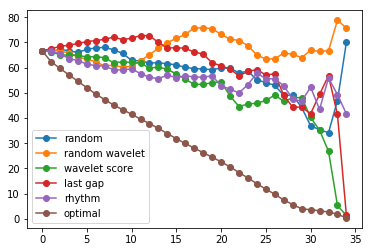

In [0]:
%%time
import math
# 總共三條線
# 實驗二＆實驗三
# random choose, random+wavelet(current), 一段時間的固定order(沒有用當下值)
sample = 5
training_ratio = 0.8

# 選擇圖表畫出來的error要如何顯示
error_show = "average error"
# error_show = "total error"
# error_show = "sigmoid inverse"  # 老師說要凸顯差異


need_to_active = range(len(stations))
s = random.choice(stations)

sample_time_range = range(int(len(origin_level_0[s]) * training_ratio), len(origin_level_0[s]))
print(sample_time_range)

# random選時間
sample_timestamp = random.sample(sample_time_range, k=sample)
# sample_timestamp 要針對變異很大的timestamp強調

def turbulent_time(sample=sample, sample_time_range=sample_time_range):
    times = {}
    for t in sample_time_range[:-1]:
        times[t] = []
#         print(t)
        for s in stations:
            value = origin_level_0[s][t+1] - origin_level_0[s][t]
            times[t].append(value)
        
        times[t] = np.var(times[t])
#         print(times[t])
    times = sorted(times.items(), key=lambda d: d[1], reverse = True)
#     print(times)
    return [t[0] for t in times[:sample]]

sample_timestamp = turbulent_time(sample, sample_time_range)

random_choose_error = []
random_current_wavelet_error = []
wavelet_order_error = []
last_gap_error = []
rhythm_week_error = []
optimal_order_error = []

# # baseline random method
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
error_logit = {}
choose_order = {}  # 有開的順序

for t in sample_timestamp:
    choose_order[t] = random.sample(stations, k=len(stations))
    
    
for i in need_to_active:
    
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:

        active = choose_order[t][:i]
        sleep = set(stations) - set(active)
           
        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)
                    
    print("compute_cnt", compute_cnt)

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0
            
    random_choose_error.append(error)   # random choose finish

if error_show == "sigmoid inverse":  # 調整error成為logit樣子
    random_choose_error = []
    for el in error_logit:
        error_logit[el] = [((i-min_bound)/(max_bound)*(0.999-0.5)) + (0.5) for i in error_logit[el]]
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        random_choose_error.append(sum(error_logit[el]))


        
# # # random choose wavelet merhod 2:
max_bound = 0
min_bound = math.inf
error_logit = {}
random_current_wavelet_error = []
choose_order = {}  # 有開的順序

points = {}
x_medians = []
y_medians = []

for t in sample_timestamp:
    x = []
    y = []
    for s in stations:
        d = (origin_level_0[s])[:t] # 產生新的data slice, 做小波
        slice_wavelet = wavelet_coefficient_table(d)
        x_ = abs(slice_wavelet[level][1][-1])
        y_ = abs(slice_wavelet[level][2][-1])
        x.append(x_)
        y.append(y_)
        points[t, s] = [x_, y_]
    avg_m = statistics.median(x)
    diff_m = statistics.median(y)
    x_medians.append(avg_m)
    y_medians.append(diff_m)
    
    diffHavgH = []
    diffHavgL = []
    diffLavgH = []
    diffLavgL = []
    # 每個sensor, 分類排好順序
    for s in stations:
        x = points[t, s][0]
        y = points[t, s][1]
        if x > avg_m and y > diff_m:
            diffHavgH.append(s)
        elif x > avg_m and y <= diff_m:
            diffLavgH.append(s)
        elif x <= avg_m and y > diff_m:
            diffHavgL.append(s)
        elif x <= avg_m and y <= diff_m:
            diffLavgL.append(s)
    choose_order[t] = random.sample(diffHavgH, k=len(diffHavgH)) + \
                      random.sample(diffHavgL, k=len(diffHavgL)) + \
                      random.sample(diffLavgH, k=len(diffLavgH)) + \
                      random.sample(diffLavgL, k=len(diffLavgL))
    
    
for i in need_to_active:
    error = 0
    compute_cnt = 0
    error_logit[i] = []

    for t in sample_timestamp:
        active = choose_order[t][:i]
        print(i, t, active)
        sleep = set(stations) - set(active)
        # compute error for sleep sensors
        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)
            
    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0
    random_current_wavelet_error.append(error)

if error_show == "sigmoid inverse":    # 調整error成為logit樣子
    random_current_wavelet_error = []
    for el in error_logit:
        error_logit[el] = [((i-min_bound)/(max_bound)*(0.999-0.5)) + (0.5) for i in error_logit[el]]
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function

        random_current_wavelet_error.append(sum(error_logit[el]))



# # # # method 3: learning from historical data
# # # # 鐵律:: sortscore (feature 1)
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
choose_order = {}
error_logit = {}


for t in sample_timestamp:
    score = wavelet_score(t, stations)
    choose_order[t] = [s[0] for s in score]
    
for i in need_to_active:
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:
#         active = [s[0] for s in sortscore[:i]]  # 先learn好的順序分數
        active = choose_order[t][:i]          # 順序會隨時間變
#         print(active)
        
        sleep = set(stations) - set(active)
        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)

        
    print(compute_cnt)
    

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0            
    wavelet_order_error.append(error)
    
if error_show == "sigmoid inverse":
    wavelet_order_error = []
    print(min_bound, max_bound)
    for el in error_logit:
        error_logit[el] = [(i-min_bound)*(0.999-0.5)/(max_bound-min_bound) + 0.5 for i in error_logit[el]]
        print("optimal", len(error_logit[el]))
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        wavelet_order_error.append(sum(error_logit[el]))
        
        
# feature 2 : last gap   
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
choose_order = {}
error_logit = {}


for t in sample_timestamp:
    
    score = last_difference_gap(t, stations)
    choose_order[t] = [s[0] for s in score]

for i in need_to_active:
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:
        
        active = choose_order[t][:i]
#         print(active)
        
        sleep = set(stations) - set(active)
        print("sleep", len(sleep))

        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)
    print(compute_cnt)
    

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0            
    last_gap_error.append(error)
    
if error_show == "sigmoid inverse":
    last_gap_error = []
    print(min_bound, max_bound)
    for el in error_logit:
        error_logit[el] = [(i-min_bound)*(0.999-0.5)/(max_bound-min_bound) + 0.5 for i in error_logit[el]]
        print("optimal", len(error_logit[el]))
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        last_gap_error.append(sum(error_logit[el]))  


# feature 3: rhythm 
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
error_logit = {}
choose_order = {}  # 有開的順序

for t in sample_timestamp:
#     choose_order[t] = rhythm(t, stations, stride=168)  # week
#     choose_order[t] = rhythm(t, stations, stride=24)   # daily
    score = rhythm(t, stations, stride=24)
    choose_order[t] = [s[0] for s in score]
    
for i in need_to_active:
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:
        
        active = choose_order[t][:i]
#         print(active)
        
        sleep = set(stations) - set(active)
        print("sleep", len(sleep))

        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)
    print(compute_cnt)
    

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0            
    rhythm_week_error.append(error)
    
if error_show == "sigmoid inverse":
    rhythm_week_error = []
    print(min_bound, max_bound)
    for el in error_logit:
        error_logit[el] = [(i-min_bound)*(0.999-0.5)/(max_bound-min_bound) + 0.5 for i in error_logit[el]]
        print("optimal", len(error_logit[el]))
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        rhythm_week_error.append(sum(error_logit[el]))

        
# # Optimal line理論上不可能找到，因為cost太高    
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
error_logit = {}
choose_order = {}  # 有開的順序

for t in sample_timestamp:
    dict = {}
    for s in stations:
        current = origin_level_0[s][t]
        estimate = [current] * (2**level)
        actual = origin_level_0[s][t+1:t+1+(2**level)]
        if len(actual) < len(estimate):
            actual = actual + ([actual[-1]]* (len(estimate)-len(actual))) # 怕長度不夠
        rms = sqrt(mean_squared_error(estimate, actual))
        dict[s] = rms
    dict = sorted(dict.items(), key=lambda d: d[1], reverse = True)

    choose_order[t] = [d[0] for d in dict]

for i in need_to_active:
    error = 0
    compute_cnt = 0
    
    error_logit[i] = []
    
    for t in sample_timestamp:  
        active = choose_order[t][:i]
        sleep = set(stations) - set(active)

        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)
        
    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0
    optimal_order_error.append(error)
    
if error_show == "sigmoid inverse":
    optimal_order_error = []
#     print(min_bound, max_bound)
    for el in error_logit:
        error_logit[el] = [(i-min_bound)*(0.999-0.5)/(max_bound-min_bound) + 0.5 for i in error_logit[el]]
#         print("optimal", len(error_logit[el]))
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        optimal_order_error.append(sum(error_logit[el]))
                

    
print(random_choose_error) 
print(random_current_wavelet_error)
# print(optimal_order_error)

plt.plot(need_to_active, random_choose_error, 'o-')
plt.plot(need_to_active, random_current_wavelet_error, 'o-')
plt.plot(need_to_active, wavelet_order_error, 'o-')
plt.plot(need_to_active, last_gap_error, 'o-')
plt.plot(need_to_active, rhythm_week_error, 'o-')
plt.plot(need_to_active, optimal_order_error, 'o-')

plt.legend(['random', 'random wavelet', 'wavelet score', 'last gap', 'rhythm','optimal'], loc='lower left')
# plt.legend(['random'], loc='lower left')

range(7585, 9482)
enter
8169
1022 cnt
[('nansanhuan_aq', 2797), ('liulihe_aq', 2763), ('fengtaihuayuan_aq', 2678), ('tongzhou_aq', 2660), ('yongledian_aq', 2658), ('qianmen_aq', 2644), ('yufa_aq', 2643), ('xizhimenbei_aq', 2636), ('yongdingmennei_aq', 2634), ('gucheng_aq', 2623), ('dongsihuan_aq', 2601), ('beibuxinqu_aq', 2585), ('dongsi_aq', 2547), ('yungang_aq', 2544), ('badaling_aq', 2539), ('pinggu_aq', 2532), ('yanqin_aq', 2524), ('daxing_aq', 2522), ('yizhuang_aq', 2510), ('wanshouxigong_aq', 2478), ('fangshan_aq', 2458), ('tiantan_aq', 2435), ('miyun_aq', 2412), ('mentougou_aq', 2407), ('wanliu_aq', 2399), ('pingchang_aq', 2379), ('shunyi_aq', 2365), ('aotizhongxin_aq', 2349), ('nongzhanguan_aq', 2333), ('donggaocun_aq', 2330), ('guanyuan_aq', 2323), ('miyunshuiku_aq', 2306), ('dingling_aq', 2304), ('huairou_aq', 2256), ('zhiwuyuan_aq', 2203)]
enter
8702
1088 cnt
[('nansanhuan_aq', 2958), ('fengtaihuayuan_aq', 2914), ('xizhimenbei_aq', 2914), ('liulihe_aq', 2908), ('tongzhou_aq'

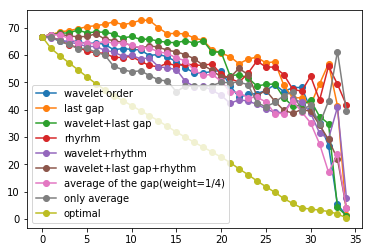

In [0]:
# 抓feature出來比較
sample = 5
training_ratio = 0.8

# 選擇圖表畫出來的error要如何顯示
error_show = "average error"
# error_show = "total error"
# error_show = "sigmoid inverse"  # 老師說要凸顯差異


need_to_active = range(len(stations))
s = random.choice(stations)

sample_time_range = range(int(len(origin_level_0[s]) * training_ratio), len(origin_level_0[s]))
print(sample_time_range)

# random選時間
sample_timestamp = random.sample(sample_time_range, k=sample)
sample_timestamp = turbulent_time(sample, sample_time_range)

def combine_feature(scores):
    weight = 1 / len(scores)
    print(weight)
    new_score = {}
    for s in stations:
        new_score[s] = 0
    for score in scores:
        print(score)
        max = score[0][1]
        min = score[-1][1]
        print(max, min)
        for station in score:
            new_score[station[0]] += (weight) * ((station[1])-min) / (max-min)
        print("new_score")
    new_score = sorted(new_score.items(), key=lambda d: d[1], reverse = True)
    return new_score
        
        
    
# 1 wavelet score
wavelet_order_error = []
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
choose_order = {}
error_logit = {}


for t in sample_timestamp:
    score = wavelet_score(t, stations)
    choose_order[t] = [s[0] for s in score]
    
for i in need_to_active:
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:
#         active = [s[0] for s in sortscore[:i]]  # 先learn好的順序分數
        active = choose_order[t][:i]          # 順序會隨時間變
#         print(active)
        
        sleep = set(stations) - set(active)
        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0            
    wavelet_order_error.append(error)
    
if error_show == "sigmoid inverse":
    wavelet_order_error = []
    print(min_bound, max_bound)
    for el in error_logit:
        error_logit[el] = [(i-min_bound)*(0.999-0.5)/(max_bound-min_bound) + 0.5 for i in error_logit[el]]
        print("optimal", len(error_logit[el]))
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        wavelet_order_error.append(sum(error_logit[el]))
        
# # 2 last lag
last_gap_error = []
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
choose_order = {}
error_logit = {}
for t in sample_timestamp:
    
    score = last_difference_gap(t, stations)
    choose_order[t] = [s[0] for s in score]

for i in need_to_active:
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:
        
        active = choose_order[t][:i]
#         print(active)
        
        sleep = set(stations) - set(active)
        print("sleep", len(sleep))

        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)
    print(compute_cnt)
    

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0            
    last_gap_error.append(error)
    
if error_show == "sigmoid inverse":
    last_gap_error = []
    print(min_bound, max_bound)
    for el in error_logit:
        error_logit[el] = [(i-min_bound)*(0.999-0.5)/(max_bound-min_bound) + 0.5 for i in error_logit[el]]
        print("optimal", len(error_logit[el]))
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        last_gap_error.append(sum(error_logit[el]))
        
# wavelet score+lag
wavelet_lag_error = []
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
choose_order = {}
error_logit = {}


for t in sample_timestamp:
    score1 = wavelet_score(t, stations)
    score2 = last_difference_gap(t, stations)
    new_score = combine_feature([score1, score2])
    choose_order[t] = [s[0] for s in new_score]
    
for i in need_to_active:
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:
#         active = [s[0] for s in sortscore[:i]]  # 先learn好的順序分數
        active = choose_order[t][:i]          # 順序會隨時間變
#         print(active)
        
        sleep = set(stations) - set(active)
        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0            
    wavelet_lag_error.append(error)
    
if error_show == "sigmoid inverse":
    wavelet_lag_error = []
    print(min_bound, max_bound)
    for el in error_logit:
        error_logit[el] = [(i-min_bound)*(0.999-0.5)/(max_bound-min_bound) + 0.5 for i in error_logit[el]]
        print("optimal", len(error_logit[el]))
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        wavelet_lag_error.append(sum(error_logit[el]))

# rhythm
rhythm_error = []
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
error_logit = {}
choose_order = {}  # 有開的順序

for t in sample_timestamp:
#     choose_order[t] = rhythm(t, stations, stride=168)  # week

    score = rhythm(t, stations, stride=24)
    choose_order[t] = [s[0] for s in score]
    
for i in need_to_active:
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:
        
        active = choose_order[t][:i]
#         print(active)
        
        sleep = set(stations) - set(active)
        print("sleep", len(sleep))

        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)
    print(compute_cnt)
    

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0            
    rhythm_error.append(error)
    
if error_show == "sigmoid inverse":
    rhythm_error = []
    print(min_bound, max_bound)
    for el in error_logit:
        error_logit[el] = [(i-min_bound)*(0.999-0.5)/(max_bound-min_bound) + 0.5 for i in error_logit[el]]
        print("optimal", len(error_logit[el]))
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        rhythm_error.append(sum(error_logit[el]))
        
# wavelet+rhythm
wavelet_rhythm_error = []
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
choose_order = {}
error_logit = {}


for t in sample_timestamp:
    score1 = wavelet_score(t, stations)
    score2 = rhythm(t, stations, stride=24)
    new_score = combine_feature([score1, score2])
    choose_order[t] = [s[0] for s in new_score]
    
for i in need_to_active:
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:
#         active = [s[0] for s in sortscore[:i]]  # 先learn好的順序分數
        active = choose_order[t][:i]          # 順序會隨時間變
#         print(active)
        
        sleep = set(stations) - set(active)
        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0            
    wavelet_rhythm_error.append(error)
    
if error_show == "sigmoid inverse":
    wavelet_rhythm_error = []
    print(min_bound, max_bound)
    for el in error_logit:
        error_logit[el] = [(i-min_bound)*(0.999-0.5)/(max_bound-min_bound) + 0.5 for i in error_logit[el]]
        print("optimal", len(error_logit[el]))
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        wavelet_rhythm_error.append(sum(error_logit[el]))

# wavelet+last gap+rhythm
wavelet_lag_rhythm_error = []
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
choose_order = {}
error_logit = {}


for t in sample_timestamp:
    score1 = wavelet_score(t, stations)
    score2 = last_difference_gap(t, stations)
    score3 = rhythm(t, stations, stride=24)
    new_score = combine_feature([score1, score2, score3])
    choose_order[t] = [s[0] for s in new_score]
    
for i in need_to_active:
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:
#         active = [s[0] for s in sortscore[:i]]  # 先learn好的順序分數
        active = choose_order[t][:i]          # 順序會隨時間變
#         print(active)
        
        sleep = set(stations) - set(active)
        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0            
    wavelet_lag_rhythm_error.append(error)
    
if error_show == "sigmoid inverse":
    wavelet_lag_rhythm_error = []
    print(min_bound, max_bound)
    for el in error_logit:
        error_logit[el] = [(i-min_bound)*(0.999-0.5)/(max_bound-min_bound) + 0.5 for i in error_logit[el]]
        print("optimal", len(error_logit[el]))
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        wavelet_lag_rhythm_error.append(sum(error_logit[el]))
        
# average of the gap: 4 features
average_of_gap_error = []
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
choose_order = {}
error_logit = {}


for t in sample_timestamp:
    score1 = wavelet_score(t, stations)
    score2 = last_difference_gap(t, stations)
    score3 = rhythm(t, stations, stride=24)
    score4 = average_gap(t, stations)
    new_score = combine_feature([score1, score2, score3, score4])
    choose_order[t] = [s[0] for s in new_score]
    
for i in need_to_active:
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:
#         active = [s[0] for s in sortscore[:i]]  # 先learn好的順序分數
        active = choose_order[t][:i]          # 順序會隨時間變
#         print(active)
        
        sleep = set(stations) - set(active)
        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0            
    average_of_gap_error.append(error)
    
if error_show == "sigmoid inverse":
    average_of_gap_error = []
    print(min_bound, max_bound)
    for el in error_logit:
        error_logit[el] = [(i-min_bound)*(0.999-0.5)/(max_bound-min_bound) + 0.5 for i in error_logit[el]]
        print("optimal", len(error_logit[el]))
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        average_of_gap_error.append(sum(error_logit[el]))

# only average no other features
average_only_error = []
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
choose_order = {}
error_logit = {}


for t in sample_timestamp:
    
    score = average_gap(t, stations)
    choose_order[t] = [s[0] for s in score]
    
for i in need_to_active:
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:
#         active = [s[0] for s in sortscore[:i]]  # 先learn好的順序分數
        active = choose_order[t][:i]          # 順序會隨時間變
#         print(active)
        
        sleep = set(stations) - set(active)
        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0            
    average_only_error.append(error)
    
if error_show == "sigmoid inverse":
    average_only_error = []
    print(min_bound, max_bound)
    for el in error_logit:
        error_logit[el] = [(i-min_bound)*(0.999-0.5)/(max_bound-min_bound) + 0.5 for i in error_logit[el]]
        print("optimal", len(error_logit[el]))
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        average_only_error.append(sum(error_logit[el]))
        

# optimal
optimal_order_error = []
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
error_logit = {}
choose_order = {}  # 有開的順序

for t in sample_timestamp:
    dict = {}
    for s in stations:
        current = origin_level_0[s][t]
        estimate = [current] * (2**level)
        actual = origin_level_0[s][t+1:t+1+(2**level)]
        if len(actual) < len(estimate):
            actual = actual + ([actual[-1]]* (len(estimate)-len(actual))) # 怕長度不夠
        rms = sqrt(mean_squared_error(estimate, actual))
        dict[s] = rms
    dict = sorted(dict.items(), key=lambda d: d[1], reverse = True)

    choose_order[t] = [d[0] for d in dict]

for i in need_to_active:
    error = 0
    compute_cnt = 0
    
    error_logit[i] = []
    
    for t in sample_timestamp:  
        active = choose_order[t][:i]
        sleep = set(stations) - set(active)

        compute_cnt, error, max_bound, min_bound= compute_sleep_error(sleep, t, error, compute_cnt, max_bound, min_bound)
        
    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0
    optimal_order_error.append(error)
    
if error_show == "sigmoid inverse":
    optimal_order_error = []
#     print(min_bound, max_bound)
    for el in error_logit:
        error_logit[el] = [(i-min_bound)*(0.999-0.5)/(max_bound-min_bound) + 0.5 for i in error_logit[el]]
#         print("optimal", len(error_logit[el]))
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        optimal_order_error.append(sum(error_logit[el]))


plt.plot(need_to_active, wavelet_order_error, 'o-')
plt.plot(need_to_active, last_gap_error, 'o-')
plt.plot(need_to_active, wavelet_lag_error, 'o-')
plt.plot(need_to_active, rhythm_error, 'o-')
plt.plot(need_to_active, wavelet_rhythm_error, 'o-')
plt.plot(need_to_active, wavelet_lag_rhythm_error, 'o-')
plt.plot(need_to_active, average_of_gap_error, 'o-')
plt.plot(need_to_active, average_only_error, 'o-')
plt.plot(need_to_active, optimal_order_error, 'o-')



plt.legend(['wavelet order', 'last gap', 'wavelet+last gap', 'rhyrhm', 'wavelet+rhythm','wavelet+last gap+rhythm','average of the gap(weight=1/4)','only average',
            'optimal'], loc='lower left')
plt.show()

enter
6697
838 cnt
[('nansanhuan_aq', 2337), ('fengtaihuayuan_aq', 2231), ('liulihe_aq', 2226), ('yongledian_aq', 2180), ('tongzhou_aq', 2177), ('gucheng_aq', 2172), ('yufa_aq', 2158), ('beibuxinqu_aq', 2151), ('dongsihuan_aq', 2146), ('yongdingmennei_aq', 2134), ('qianmen_aq', 2127), ('xizhimenbei_aq', 2122), ('badaling_aq', 2115), ('yungang_aq', 2114), ('yizhuang_aq', 2101), ('dongsi_aq', 2080), ('yanqin_aq', 2079), ('daxing_aq', 2072), ('pinggu_aq', 2068), ('fangshan_aq', 2032), ('wanliu_aq', 1996), ('tiantan_aq', 1990), ('wanshouxigong_aq', 1986), ('pingchang_aq', 1983), ('mentougou_aq', 1965), ('miyun_aq', 1955), ('dingling_aq', 1923), ('shunyi_aq', 1921), ('miyunshuiku_aq', 1909), ('aotizhongxin_aq', 1904), ('guanyuan_aq', 1895), ('donggaocun_aq', 1892), ('nongzhanguan_aq', 1882), ('huairou_aq', 1856), ('zhiwuyuan_aq', 1788)]
['nansanhuan_aq', 'fengtaihuayuan_aq', 'liulihe_aq', 'yongledian_aq', 'tongzhou_aq', 'gucheng_aq', 'yufa_aq', 'beibuxinqu_aq', 'dongsihuan_aq', 'yongdingmen

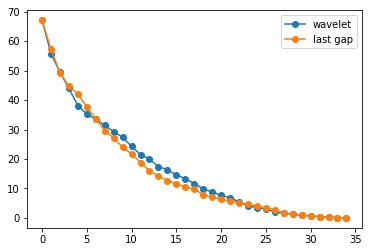

In [0]:
# Extract Features
sample = 3
# feature 1: wavelet score
def wavelet_score(time, stations):
    # 從0學到t-1的score
    print("enter")
    score = {}
    avgs = []
    diffs = []
    case_cnt = {}
    
    for s in stations:
        d = origin_level_0[s][:time]
#         print(d)
        slice_wavelet = wavelet_coefficient_table(d)
        avg = slice_wavelet[level][1]
        diff = slice_wavelet[level][2]
        avgs.append(avg)
        diffs.append(diff)
        case_cnt[s] = Counter()
        
    # 算出總共多少個小波值，一個由一組(x, y)組成
    wavelet_cnt = len(avgs[0])
    print(time)
    print(wavelet_cnt, "cnt")
    for w in range(wavelet_cnt):
        sensor_avg = [i[w] for i in avgs]
        sensor_diff = [i[w] for i in diffs]
#         print(len(sensor_avg))
        xm = statistics.median(sensor_avg)
        ym = statistics.median(sensor_diff)
#         print(sensor_avg)  # 35 values
        for x, y, s in zip(sensor_avg, sensor_diff, stations):
            if x > xm and y > ym:
                case_cnt[s].diffHavgH += 1
            elif x > xm and y <= ym:
                case_cnt[s].diffLavgH += 1
            elif x <= xm and y > ym:
                case_cnt[s].diffHavgL += 1
            elif x <= xm and y <= ym:
                case_cnt[s].diffLavgL += 1
    # 計算小波分數
    for s in stations: 
        score[s] = 4*case_cnt[s].diffHavgH+\
                   3*case_cnt[s].diffHavgL+\
                   2*case_cnt[s].diffLavgH+\
                   1*case_cnt[s].diffLavgL
    score = sorted(score.items(), key=lambda d: d[1], reverse = True)
    print(score)
                
    return [s[0] for s in score]

# feature2: 只看上一次的difference
def last_difference_gap(time, stations):
    gaps = {}
    for s in stations:
        gaps[s] = origin_level_0[s][time]-origin_level_0[s][time-1]
        gaps[s] = abs(gaps[s])
        
    score = sorted(gaps.items(), key=lambda d: d[1], reverse = True)
    return [s[0] for s in score]



sample_timestamp = random.sample(sample_time_range, k=sample)
choose_order = {}

for t in sample_timestamp:
    choose_order[t] = wavelet_score(t, stations)
    print(choose_order[t])
    
    choose_order[t] = last_difference_gap(t, stations)
    print(choose_order[t])
    
# sample_timestamp = turbulent_time(sample, sample_time_range)
    
# # feature- wavelet score
# feature errors
wavelet_score_error = []
last_difference_gap_error = []

# 選擇圖表畫出來的error要如何顯示
# error_show = "average error"
# error_show = "total error"
error_show = "sigmoid inverse"  # 老師說要凸顯差異


# wavelet_score
max_bound = 0 # for inverse sigmoid
min_bound = math.inf
error_logit = {}
choose_order = {}  # 有開的順序

for t in sample_timestamp:
    choose_order[t] = wavelet_score(t, stations)
    
    
for i in need_to_active:
    
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:

        active = choose_order[t][:i]
        sleep = set(stations) - set(active)

        for s in sleep:
            current = origin_level_0[s][t]
            estimate = [current] * (2**level)
            actual = origin_level_0[s][t+1:t+1+(2**level)]
            if len(actual) < len(estimate):
                actual = actual + ([actual[-1]]* (len(estimate)-len(actual))) # 怕長度不夠
            rms = sqrt(mean_squared_error(estimate, actual))
            error += rms
            compute_cnt += 1
            
            if error > max_bound:
                max_bound = error
            if error < min_bound:
                min_bound = error
            error_logit[i].append(error)
            
    print("compute_cnt", compute_cnt)

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0
            
    wavelet_score_error.append(error)   

if error_show == "sigmoid inverse":  # 調整error成為logit樣子
    wavelet_score_error = []
    for el in error_logit:
        error_logit[el] = [((i-min_bound)/(max_bound)*(0.999-0.5)) + (0.5) for i in error_logit[el]]
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        wavelet_score_error.append(sum(error_logit[el]))

# feature2  

max_bound = 0 # for inverse sigmoid
min_bound = math.inf
error_logit = {}
choose_order = {}  # 有開的順序

for t in sample_timestamp:
    choose_order[t] = last_difference_gap(t, stations)
    
    
for i in need_to_active:
    
    error = 0
    compute_cnt = 0
    error_logit[i] = []
    
    for t in sample_timestamp:

        active = choose_order[t][:i]
        sleep = set(stations) - set(active)

        for s in sleep:
            current = origin_level_0[s][t]
            estimate = [current] * (2**level)
            actual = origin_level_0[s][t+1:t+1+(2**level)]
            if len(actual) < len(estimate):
                actual = actual + ([actual[-1]]* (len(estimate)-len(actual))) # 怕長度不夠
            rms = sqrt(mean_squared_error(estimate, actual))
            error += rms
            compute_cnt += 1
            
            if error > max_bound:
                max_bound = error
            if error < min_bound:
                min_bound = error
            error_logit[i].append(error)
            
    print("compute_cnt", compute_cnt)

    if error_show == "average error":
        if compute_cnt > 0:
            error = error / compute_cnt
        else:
            error = 0
            
    last_difference_gap_error.append(error)  

if error_show == "sigmoid inverse":  # 調整error成為logit樣子
    last_difference_gap_error = []
    for el in error_logit:
        error_logit[el] = [((i-min_bound)/(max_bound)*(0.999-0.5)) + (0.5) for i in error_logit[el]]
        error_logit[el] = [math.log(i/(1-i),10) for i in error_logit[el]]  # 帶入function
        last_difference_gap_error.append(sum(error_logit[el]))

        
plt.plot(need_to_active, wavelet_score_error, 'o-', label='wavelet')
plt.plot(need_to_active, last_difference_gap_error, 'o-', label='last gap')
plt.legend()
plt.show()

In [0]:
# testing cell
import random

        
class Schedule(object):
    def __init__(self, stations, simultaneously_sleep, 
                 remain_bettery, remain_sleep, starttime):
        self.info = {}
        self.simultaneously_sleep = simultaneously_sleep
        self.starttime = starttime
        self.errors = []
        self.extend = []
        for s in stations:
            self.info[s] = {'remain_bettery' : remain_bettery, 'remain_sleep' : remain_sleep}
        self.chooser = ManyChooser()
    def print_battery(self):
        print(self.info)
        
class ManyChooser(object):
    def random_chooser(self, list, i):
#         print("123")
        return random.sample(list, k=i)
    def wavelet_random_chooser(self, list, t, i):
        wavelet_value = {}
        for i, element in enumerate(list):
            wavelet_value[element] = i
        print(wavelet_value)
        
# a = [1, 3, 4, 6, 7]
# chooser = ManyChooser()
# b = chooser.random_chooser(a, 2)
# b = chooser.wavelet_random_chooser(a, 4, 2)
# print(b)

sensors = ['a', 'b', 'c', 'd', 'e']
simultaneously_sleep = 2
remain_bettery = 5
remain_sleep = 4
starttime = 0
s1 = Schedule(sensors, simultaneously_sleep, remain_bettery, remain_sleep, starttime=0)
for i in range(5):
    slot = []
    result = s1.chooser.random_chooser(sensors, simultaneously_sleep)
    print(result)
    for r in result:
        s1.info[r]['remain_sleep'] -= 1
    s1.print_battery()


['d', 'b']
{'a': {'remain_bettery': 5, 'remain_sleep': 4}, 'b': {'remain_bettery': 5, 'remain_sleep': 3}, 'c': {'remain_bettery': 5, 'remain_sleep': 4}, 'd': {'remain_bettery': 5, 'remain_sleep': 3}, 'e': {'remain_bettery': 5, 'remain_sleep': 4}}
['c', 'a']
{'a': {'remain_bettery': 5, 'remain_sleep': 3}, 'b': {'remain_bettery': 5, 'remain_sleep': 3}, 'c': {'remain_bettery': 5, 'remain_sleep': 3}, 'd': {'remain_bettery': 5, 'remain_sleep': 3}, 'e': {'remain_bettery': 5, 'remain_sleep': 4}}
['a', 'e']
{'a': {'remain_bettery': 5, 'remain_sleep': 2}, 'b': {'remain_bettery': 5, 'remain_sleep': 3}, 'c': {'remain_bettery': 5, 'remain_sleep': 3}, 'd': {'remain_bettery': 5, 'remain_sleep': 3}, 'e': {'remain_bettery': 5, 'remain_sleep': 3}}
['d', 'e']
{'a': {'remain_bettery': 5, 'remain_sleep': 2}, 'b': {'remain_bettery': 5, 'remain_sleep': 3}, 'c': {'remain_bettery': 5, 'remain_sleep': 3}, 'd': {'remain_bettery': 5, 'remain_sleep': 2}, 'e': {'remain_bettery': 5, 'remain_sleep': 2}}
['d', 'a']
{

下面的不重要

In [0]:
# 看不懂

from pywt import wavedec
coeffs = wavedec([1,1,6,8,9,11,15,25], 'haar', level=2)
cA2, cD2, cD1 = coeffs

# import pywt
# (cA, cD) = pywt.dwt([1,1,6,8,9,11,15,25], 'haar')
root2 = lambda i: [x/2**0.5 for x in i]
# print(cA, cD)
# root2(cD)
for i in coeffs:
    a = root2(i)
    print(a)


[5.6568542494923815, 21.21320343559643]
[-4.2426406871192865, -7.071067811865476]
[0.0, -0.9999999999999999, -0.9999999999999999, -5.0]


In [0]:
# 暴力: autocorrelation
data = [266,145.9,183.1,119.3,180.3,168.5,231.8,224.5,192.8,122.9,336.5,185.9,194.3,149.5,210.1,273.3,191.4,287,226,303.6,289.9,421.6,264.5,342.3,339.7,440.4,315.9,439.3,401.3,437.4,575.5,407.6,682,475.3,581.3,646.9]
print(len(data))

# data = data[:5]
# data = [2, 3, -1]
for i, ei in reversed(list(enumerate(data))):
    print(i, ei)
    row = [0]*i
    for ej in reversed(data):
        row.insert(0, ei*ej)
    for j in range(len(data)-1-i):
        row.insert(0, 0)
    print(row)
        


36
35 646.9
[172075.4, 94382.71, 118447.39, 77175.17, 116636.07, 109002.65, 149951.42, 145229.05, 124722.32, 79504.01, 217681.85, 120258.71, 125692.67, 96711.55, 135913.69, 176797.77, 123816.66, 185660.3, 146199.4, 196398.84, 187536.30999999997, 272733.04, 171105.05, 221433.87, 219751.93, 284894.75999999995, 204355.71, 284183.17, 259600.97, 282954.06, 372290.95, 263676.44, 441185.8, 307471.57, 376042.97, 418479.61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
34 581.3
[0, 154625.8, 84811.67, 106436.02999999998, 69349.09, 104808.39, 97949.04999999999, 134745.34, 130501.84999999999, 112074.64, 71441.77, 195607.44999999998, 108063.67, 112946.59, 86904.34999999999, 122131.12999999999, 158869.29, 111260.81999999999, 166833.09999999998, 131373.8, 176482.68, 168518.86999999997, 245076.08, 153753.84999999998, 198978.99, 197467.61, 256004.51999999996, 183632.66999999998, 255365.09, 233275.69, 254260.61999999997, 334538.14999999997, 236

In [0]:
# 先把how to difine pattern的問題跳過：就當作我label出來的東西已經是pattern
def pattern_count(array2d):
    # a boolean 2d array for time to indict it is pattern or not, return times for pattern count


# The hardest problem is "predict"